# *Starting*

Libraries

In [1]:
!pip install gensim

In [2]:
!pip install --upgrade gensim

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import string
import seaborn as sns
import re
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

Dataset read

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Academic/Practice/IMDB Dataset.csv")
data.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

# *Understanding the Data*

In [5]:
# Check the number of rows and columns in the dataset
num_rows, num_cols = data.shape
print(f"\nNumber of rows: {num_rows}, Number of columns: {num_cols}")


Number of rows: 50000, Number of columns: 2


In [6]:
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
review       0
sentiment    0
dtype: int64


In [7]:
data.describe()

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

In [8]:
# Explore Sentiment Distribution
sentiment_distribution = data['sentiment'].value_counts()
print("\nSentiment Distribution:")
print(sentiment_distribution)


Sentiment Distribution:
positive    25000
negative    25000
Name: sentiment, dtype: int64


In [9]:
# Analyze Text Characteristics
def analyze_text_characteristics(data):
    # Sample a few reviews for analysis
    sample_reviews = data['review'].sample(n=5, random_state=42)  # Sample 5 reviews for analysis

    print("\nSample Reviews:")
    for idx, review in enumerate(sample_reviews):
        print(f"\nReview {idx+1}:")
        print(review)

    # Calculate average review length
    avg_review_length = data['review'].apply(lambda x: len(x.split())).mean()
    print("\nAverage Review Length (in words):", avg_review_length)

    # Identify common patterns or challenges
    # For example, you can check for common words, special characters, or patterns specific to movie reviews.

# Call the function to analyze text characteristics
analyze_text_characteristics(data)



Sample Reviews:

Review 1:
I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok to have a huge fat man vs a strong man but I'm glad times have changed. It was a terrible main event just like every match Luger is in is terrible. Other matches on the card were Razor Ramon vs Ted Dibiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt Hening, this was the event where Shawn named his big monster of a body guard Diesel, IRS vs 1-2-3 Kid, Bret Hart first takes on Doink then takes on Jerry Lawler and stuff with the Harts and Lawler was always very interesting, then Ludvig Borga destroyed Marty Jannetty, Undertaker took on Giant Gonzalez in another terrible match, The Smoking Gunns and Tatanka took on Bam Bam Bigelow and the Headshrinker

In [10]:
# Document Observations
def document_observations(data):
    observations = {}

    # Record basic statistics
    observations['num_rows'] = data.shape[0]
    observations['num_cols'] = data.shape[1]
    observations['missing_values'] = data.isnull().sum()
    observations['sentiment_distribution'] = data['sentiment'].value_counts()

    # Analyze text characteristics
    avg_review_length = data['review'].apply(lambda x: len(x.split())).mean()
    observations['avg_review_length'] = avg_review_length

    # Additional observations can be recorded here...

    return observations

# Call the function to document observations
data_observations = document_observations(data)

# Print the documented observations
print("\nDocumented Observations:")
for key, value in data_observations.items():
    print(f"{key}: {value}")



Documented Observations:
num_rows: 50000
num_cols: 2
missing_values: review       0
sentiment    0
dtype: int64
sentiment_distribution: positive    25000
negative    25000
Name: sentiment, dtype: int64
avg_review_length: 231.15694


Bar Chart of Sentiment Distribution

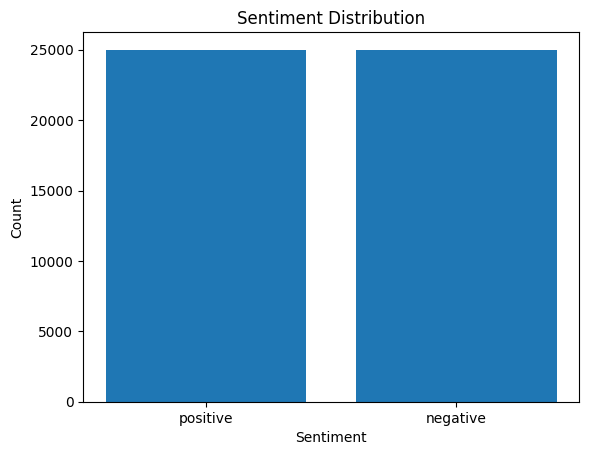

In [11]:
sentiment_distribution = data['sentiment'].value_counts()
plt.bar(sentiment_distribution.index, sentiment_distribution.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


Word Clouds for Positive and Negative Reviews

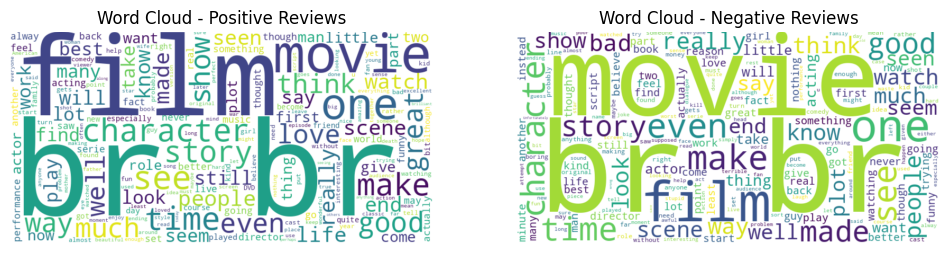

In [12]:
positive_reviews = data[data['sentiment'] == 'positive']['review']
negative_reviews = data[data['sentiment'] == 'negative']['review']

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')

plt.show()

*Box Plot of Review Length by Sentiment:* showing the distribution of review lengths for each sentiment category

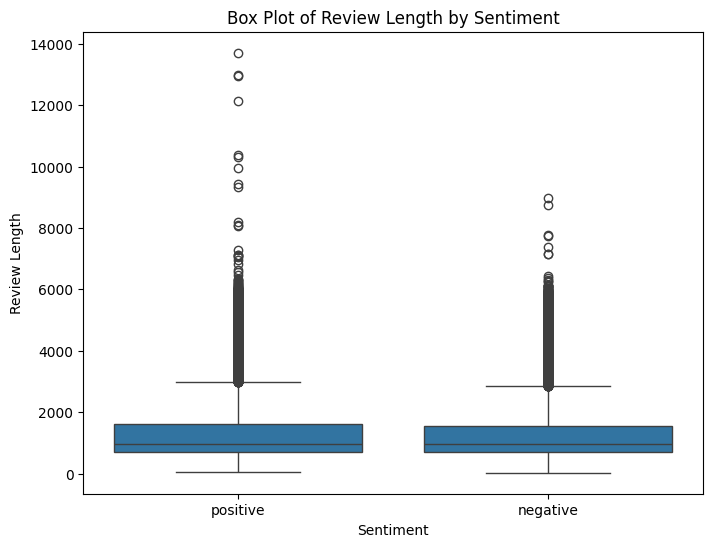

In [13]:
plt.figure(figsize=(8, 6))
data['review_length'] = data['review'].apply(len)
sns.boxplot(x='sentiment', y='review_length', data=data)
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.title('Box Plot of Review Length by Sentiment')
plt.show()


# *Data Preprocessing*

*Lowercasing*: Convert all text to lowercase to ensure consistency

In [14]:
data['review'] = data['review'].str.lower()


*Tokenization*

In [15]:
nltk.download('punkt')  # Download punkt tokenizer
data['review_tokens'] = data['review'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


*Removing Punctuation*

In [16]:
data['review'] = data['review'].str.replace('[{}]'.format(string.punctuation), '')


<ipython-input-16-ed3b2c4df908>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['review'] = data['review'].str.replace('[{}]'.format(string.punctuation), '')


*Removing Stop Words*

In [17]:
nltk.download('stopwords')  # Download stopwords corpus
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
data['review_tokens'] = data['review_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


*Lemmatization*

In [18]:
nltk.download('wordnet')  # Download wordnet lemmatizer
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
data['review_tokens'] = data['review_tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [19]:
data.head()

review sentiment  review_length  \
0  one of the other reviewers has mentioned that ...  positive           1761   
1  a wonderful little production br br the filmin...  positive            998   
2  i thought this was a wonderful way to spend ti...  positive            926   
3  basically theres a family where a little boy j...  negative            748   
4  petter matteis love in the time of money is a ...  positive           1317   

                                       review_tokens  
0  [one, reviewer, mentioned, watching, 1, oz, ep...  
1  [wonderful, little, production, ., <, br, /, >...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, 's, family, little, boy, (, jake, ...  
4  [petter, mattei, 's, ``, love, time, money, ''...

Removing punctuations, *br*, empty strings, single character strings from *review_tokens*

In [20]:
def clean_tokens(tokens):
    """
    Cleans a list of tokens by removing punctuation, empty strings,
    'br', and single character strings.

    Args:
        tokens: A list of tokens.

    Returns:
        A cleaned list of tokens.
    """

    punctuation_chars = string.punctuation
    translator = str.maketrans('', '', punctuation_chars)

    # Remove punctuation
    tokens = [token.translate(translator) for token in tokens]

    # Remove empty strings and 'br'
    tokens = [token for token in tokens if token != '' and token != 'br']

    # # Remove single character strings except digit
    # tokens = [token for token in tokens if len(token) > 1 or not token.isdigit()]

    return tokens

data['review_tokens'] = data['review_tokens'].apply(clean_tokens)

In [21]:
data["review_tokens_length"] = [len(tokens) for tokens in data["review_tokens"]]

In [22]:
data.head()

review sentiment  review_length  \
0  one of the other reviewers has mentioned that ...  positive           1761   
1  a wonderful little production br br the filmin...  positive            998   
2  i thought this was a wonderful way to spend ti...  positive            926   
3  basically theres a family where a little boy j...  negative            748   
4  petter matteis love in the time of money is a ...  positive           1317   

                                       review_tokens  review_tokens_length  
0  [one, reviewer, mentioned, watching, 1, oz, ep...                   172  
1  [wonderful, little, production, filming, techn...                    86  
2  [thought, wonderful, way, spend, time, hot, su...                    87  
3  [basically, s, family, little, boy, jake, thin...                    69  
4  [petter, mattei, s, love, time, money, visuall...                   128

*review_length*

In [23]:
data['review_length'].plot(kind='hist', bins=20, title='review_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

*review_tokens_length*

In [24]:
data['review_tokens_length'].plot(kind='hist', bins=20, title='review_tokens_length')
plt.gca().spines[['top', 'right',]].set_visible(False)

*review_length vs review_tokens_length*

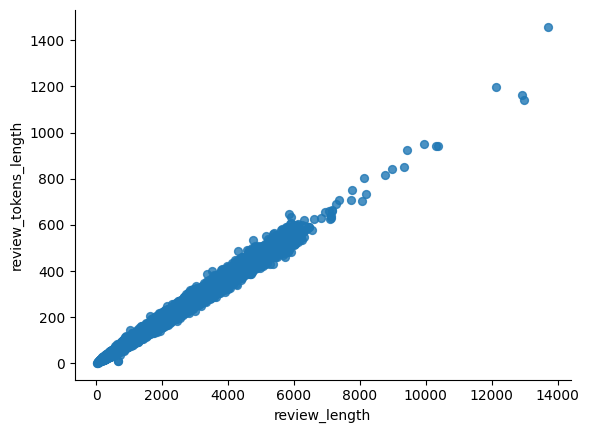

In [25]:
data.plot(kind='scatter', x='review_length', y='review_tokens_length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

# *Feature Extraction*

*Word Embedding: word2vec*

In [26]:
# Train Word2Vec model on tokenized reviews
word2vec_model = gensim.models.Word2Vec(data['review_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Convert tokenized reviews to average word embeddings
X_word2vec = []
for tokens in data['review_tokens']:
    word_embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if word_embeddings:
        review_embedding = np.mean(word_embeddings, axis=0)
    else:
        review_embedding = np.zeros(word2vec_model.vector_size)
    X_word2vec.append(review_embedding)
X_word2vec = np.array(X_word2vec)

# *Data splitting*

In [27]:
# Define the ratios for train, test, and validation sets
train_ratio = 0.75
test_ratio = 0.15
validation_ratio = 0.10

# Split the dataset into train and temp sets
train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=42, shuffle=True)

# Split the temp set into test and validation sets
test_data, validation_data = train_test_split(temp_data, train_size=test_ratio/(test_ratio + validation_ratio), random_state=42, shuffle=True)

# Print the sizes of the train, test, and validation sets
print("Train set size:", len(train_data))
print("Test set size:", len(test_data))
print("Validation set size:", len(validation_data))

Train set size: 37500
Test set size: 7500
Validation set size: 5000


In [28]:
# Check for data integrity
assert len(set(train_data.index) & set(test_data.index)) == 0, "Overlap between train and test sets"
assert len(set(train_data.index) & set(validation_data.index)) == 0, "Overlap between train and validation sets"
assert len(set(test_data.index) & set(validation_data.index)) == 0, "Overlap between test and validation sets"

# Check for handling unseen data
train_sentiments = set(train_data['sentiment'])
test_sentiments = set(test_data['sentiment'])
validation_sentiments = set(validation_data['sentiment'])

assert test_sentiments.issubset(train_sentiments), "Test set contains unseen sentiments"
assert validation_sentiments.issubset(train_sentiments), "Validation set contains unseen sentiments"

In [31]:
# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []
validation_accuracies = []

# Define the training, testing, and validation data
X_train, y_train = train_data['review'], train_data['sentiment']
X_test, y_test = test_data['review'], test_data['sentiment']
X_validation, y_validation = validation_data['review'], validation_data['sentiment']


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Define text vectorization and model pipelines
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression())
])

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC())
])

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', XGBClassifier())
])

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB())
])

# Train and evaluate each model
for name, model in [('Logistic Regression', lr_pipeline),
                    ('SVM', svm_pipeline),
                    ('Random Forest', rf_pipeline),
                    ('XGBoost', xgb_pipeline),
                    ('Naive Bayes', nb_pipeline)]:
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("="*50)


Training Logistic Regression...
Logistic Regression Accuracy: 0.9020
Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      3642
    positive       0.90      0.91      0.91      3858

    accuracy                           0.90      7500
   macro avg       0.90      0.90      0.90      7500
weighted avg       0.90      0.90      0.90      7500

Training SVM...
SVM Accuracy: 0.9073
SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      3642
    positive       0.90      0.92      0.91      3858

    accuracy                           0.91      7500
   macro avg       0.91      0.91      0.91      7500
weighted avg       0.91      0.91      0.91      7500

Training Random Forest...
Random Forest Accuracy: 0.8451
Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['negative' 'positive']

In [ ]:
# Display train, test, and validation accuracies for each model
models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost', 'Naive Bayes']
for model, train_acc, test_acc, validation_acc in zip(models, train_accuracies, test_accuracies, validation_accuracies):
    print(f"{model}:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Validation Accuracy: {validation_acc:.4f}")
    print("="*50)


In [19]:
import pandas as pd
from google.colab import files

# Save the dataframe to a CSV file
data.to_csv('data.csv')

# Download the CSV file
files.download('data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>